In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ------------------------------
# 0) Utilities
# ------------------------------
def ann_factor(): return 12

def annualized_ret(r):
    r = r.dropna()
    if len(r) == 0: return np.nan
    k = ann_factor()
    return (1+r).prod()**(k/len(r)) - 1

def annualized_vol(r):
    r = r.dropna()
    return r.std() * np.sqrt(ann_factor()) if r.std() > 0 else np.nan

def sharpe(r, rf=0.0):
    r = r.dropna()
    if r.empty: return np.nan
    ex = r - rf/ann_factor()
    sd = ex.std()
    return (ex.mean()/sd)*np.sqrt(ann_factor()) if sd>0 else np.nan

def sortino(r, rf=0.0):
    r = r.dropna()
    if r.empty: return np.nan
    ex = r - rf/ann_factor()
    dn = ex[ex<0].std()
    return (ex.mean()/dn)*np.sqrt(ann_factor()) if (dn and not np.isnan(dn)) else np.nan

def max_drawdown(curve):
    peak = curve.cummax()
    dd = curve/peak - 1.0
    return dd.min()

def turnover(weights_df):
    # monthly turnover proxy = 0.5 * sum |w_t - w_{t-1}| across assets
    dw = weights_df.diff().abs().sum(axis=1)
    return (0.5 * dw).mean()

@dataclass
class BTResult:
    returns: pd.Series
    weights: pd.DataFrame
    curve: pd.Series
    stats: dict

def backtest(returns_df, weights_df, trans_cost_bps=0.0):
    # aligns index
    rets = returns_df.reindex(weights_df.index).dropna()
    w    = weights_df.reindex(rets.index).fillna(0.0)
    port_ret = (w * rets).sum(axis=1)
    if trans_cost_bps>0:
        tw = w.diff().abs().sum(axis=1)*0.5
        port_ret -= tw * (trans_cost_bps/1e4)
    curve = (1+port_ret).cumprod()
    stats = {
        'AnnRet'  : annualized_ret(port_ret),
        'AnnVol'  : annualized_vol(port_ret),
        'Sharpe'  : sharpe(port_ret),
        'Sortino' : sortino(port_ret),
        'MaxDD'   : max_drawdown(curve),
        'Turnover': turnover(w)
    }
    return BTResult(port_ret, w, curve, stats)

In [2]:
df = pd.read_csv('../../../data/processed/regime_strategy_info_result.csv', index_col=0, parse_dates=True)
df

,p_recession,ret_eq,ret_bond,ret_cash,r_port,w_bond,w_eq,w_cash,state
1997-02-28,0.134124,0.009566,0.000984,0.004175,0.008415,0.134124,0.865876,0.000000,0
1997-03-31,0.077201,-0.044123,-0.013035,0.004283,-0.040318,0.122380,0.877620,0.000000,0
1997-04-30,0.051048,0.062603,0.016122,0.004300,0.057599,0.107664,0.892336,0.000000,0
1997-05-31,0.066194,0.063207,0.008343,0.004208,0.057770,0.099109,0.900891,0.000000,0
1997-06-30,0.068870,0.041103,0.010031,0.004108,0.038217,0.092871,0.907129,0.000000,0
...,...,...,...,...,...,...,...,...,...
2022-06-30,0.996404,-0.082460,-0.008270,0.001242,-0.002153,0.973886,0.026114,0.973886,1
2022-07-31,0.996713,0.092087,0.019216,0.001858,0.020776,0.978595,0.021405,0.000000,1
2022-08-31,0.996134,-0.040802,-0.029085,0.002192,-0.000726,0.982213,0.017787,0.982213,1
2022-09-30,0.995388,-0.092446,-0.032555,0.002608,-0.001393,0.984931,0.015069,0.984931,1


Saved 11_hysteresis_sensitivity.csv
IC(p_recession, 12m fwd EQ) = -0.252


/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_78594/1339227128.py:129: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.reindex(returns_df.index).fillna(method='ffill').fillna(0).astype(int)
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_78594/1339227128.py:129: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.reindex(returns_df.index).fillna(method='ffill').fillna(0).astype(int)
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_78594/1339227128.py:129: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.reindex(returns_df.index).fillna(method='ffill').fillna(0).astype(int)
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_78594/1339227128.py:129: FutureWarning: Seri

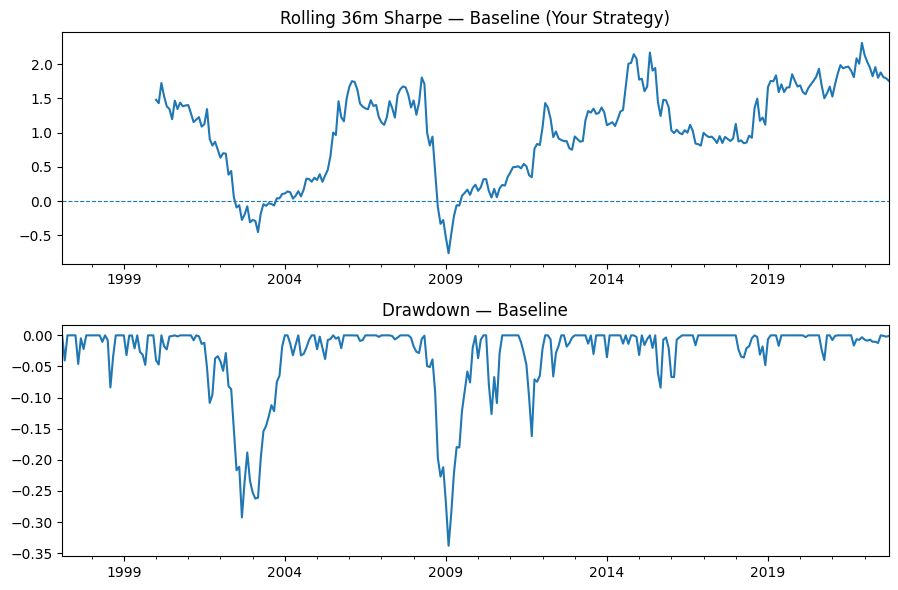

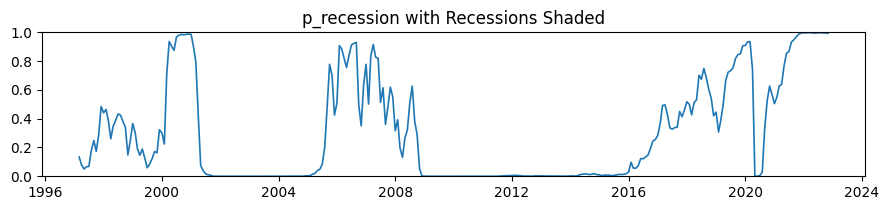

In [3]:

# ------------------------------
# 1) Prepare series and assets
# ------------------------------
# Required series existence checks
assert 'r_port' in df and 'w_bond' in df and 'state' in df, "res must have r_port, w_bond, state"
assert 'ret_eq' in df.columns and 'ret_bond' in df.columns and 'p_recession' in df.columns, "df must have ret_eq, ret_bond, p_recession"

# Build weights used in your strategy (assuming Eq/Bond/Cash; if no cash, it will be 0)
W_base = pd.DataFrame(index=df['w_bond'].index, columns=['ret_eq','ret_bond','ret_cash'], dtype=float)
W_base['ret_bond'] = df['w_bond'].clip(0,1)
W_base['ret_eq']   = 1.0 - W_base['ret_bond']
# If you actually had a cash sleeve, infer it if provided, else set to 0
if 'ret_cash' in df.columns:
    # if user’s weights truly sum to <1, use the residual as cash (else 0)
    residual = 1.0 - (W_base['ret_eq'] + W_base['ret_bond'])
    W_base['ret_cash'] = residual.clip(lower=0.0).fillna(0.0)
    # renormalize to 1 (defensive)
    W_base = W_base.div(W_base.sum(axis=1), axis=0).fillna(0.0)
else:
    W_base['ret_cash'] = 0.0

# Asset returns matrix
assets = ['ret_eq','ret_bond'] + (['ret_cash'] if 'ret_cash' in df.columns else [])
returns_df = df[assets].copy()

# ------------------------------
# 2) Baseline backtest & benchmarks
# ------------------------------
# Baseline: use *your* realized portfolio returns directly (no recomputation)
bt_base = BTResult(
    returns=df['r_port'].dropna().reindex(returns_df.index).dropna(),
    weights=W_base.reindex(returns_df.index).fillna(0.0),
    curve=(1+df['r_port'].dropna().reindex(returns_df.index).dropna()).cumprod(),
    stats={}
)
bt_base.stats = {
    'AnnRet'  : annualized_ret(bt_base.returns),
    'AnnVol'  : annualized_vol(bt_base.returns),
    'Sharpe'  : sharpe(bt_base.returns),
    'Sortino' : sortino(bt_base.returns),
    'MaxDD'   : max_drawdown(bt_base.curve),
    'Turnover': turnover(bt_base.weights)
}

# 60/40 benchmark (Eq/Bond)
W_6040 = pd.DataFrame(index=returns_df.index, columns=assets, data=0.0)
W_6040['ret_eq']   = 0.60
W_6040['ret_bond'] = 0.40
bt_6040 = backtest(returns_df, W_6040, trans_cost_bps=0)

# Cash benchmark (if available)
if 'ret_cash' in df.columns:
    W_cash = pd.DataFrame(index=returns_df.index, columns=assets, data=0.0)
    W_cash['ret_cash'] = 1.0
    bt_cash = backtest(returns_df, W_cash, trans_cost_bps=0)
else:
    bt_cash = None

# ------------------------------
# 3) Rolling 36m Sharpe & drawdown plot
# ------------------------------
def rolling_sharpe(r, win=36):
    mu = r.rolling(win).mean()
    sd = r.rolling(win).std()
    return (mu/sd)*np.sqrt(12)

roll_shp = rolling_sharpe(bt_base.returns, win=36)
dd = bt_base.curve/bt_base.curve.cummax() - 1

plt.figure(figsize=(9,6))
plt.subplot(2,1,1)
roll_shp.plot()
plt.title('Rolling 36m Sharpe — Baseline (2 Regime Strategy)')
plt.axhline(0, ls='--', lw=0.8)
plt.subplot(2,1,2)
dd.plot()
plt.title('Drawdown — Baseline')
plt.tight_layout()

# ------------------------------
# 4) Regime Consistency (use your existing res["state"])
# ------------------------------
# state is your risk-off flag; if df has NBER 'recession' (0/1), compute TP/FP/FN by decade
state = df['state'].reindex(returns_df.index).fillna(0).astype(int)
if 'recession' in df.columns:
    dec = (returns_df.index.year // 10) * 10
    tab = (pd.DataFrame({'recession': df['recession'].astype(int).reindex(returns_df.index).fillna(0),
                         'risk_off': state,
                         'decade': dec})
           .groupby('decade')
           .apply(lambda g: pd.Series({
               'TP_rate': ((g['recession']==1)&(g['risk_off']==1)).mean(),
               'FP_rate': ((g['recession']==0)&(g['risk_off']==1)).mean(),
               'FN_rate': ((g['recession']==1)&(g['risk_off']==0)).mean()
           })))
    print("Decade-wise regime consistency:\n", tab.round(3))

# Plot p_recession with recession shading (if available)
plt.figure(figsize=(9,2.2))
plt.plot(df['p_recession'].reindex(returns_df.index).clip(0,1), lw=1.2, label='p_recession')
if 'recession' in df.columns:
    plt.fill_between(returns_df.index, 0, 1,
                     where=df['recession'].reindex(returns_df.index).fillna(0).astype(bool),
                     alpha=0.20, step='pre', label='NBER recessions')
plt.ylim(0,1)
plt.title('p_recession with Recessions Shaded')
plt.tight_layout()

# ------------------------------
# 5) Hysteresis Sensitivity (diagnostic only)
#     We DO NOT change your baseline strategy. We overlay a tiny 15% Eq→Bond tilt
#     when an alternative state (derived from p_recession) is ON. This tests robustness to thresholds.
# ------------------------------
def hysteresis_state_from_p(p, on=0.60, off=0.50, k=2):
    # 0=on, 1=off with k-month confirmation
    p = p.clip(0,1).dropna()
    s = pd.Series(index=p.index, dtype=int)
    s.iloc[0] = 0
    run, prev = 0, 0
    for t in range(1, len(p)):
        state = prev
        trigger = (p.iloc[t]>=on and prev==0) or (p.iloc[t]<=off and prev==1)
        run = run+1 if trigger else 1
        if p.iloc[t]>=on and prev==0 and run>=k: state = 1
        if p.iloc[t]<=off and prev==1 and run>=k: state = 0
        s.iloc[t], prev = state, state
    return s.reindex(returns_df.index).fillna(method='ffill').fillna(0).astype(int)

def apply_tilt(W, state, tilt=0.15):
    if 'ret_eq' not in W or 'ret_bond' not in W:
        raise ValueError("W must have 'ret_eq' and 'ret_bond'")
    Wt = W.copy()
    shift = (Wt['ret_eq'] * tilt * state).fillna(0)
    Wt['ret_eq']  = (Wt['ret_eq']  - shift).clip(lower=0)
    Wt['ret_bond'] = (Wt['ret_bond'] + shift).clip(lower=0)
    Wt = Wt.div(Wt.sum(axis=1), axis=0).fillna(0.0)
    return Wt

grid = []
p = df['p_recession'].reindex(returns_df.index)
for on in [0.55,0.60,0.65,0.70]:
    for off in [0.40,0.45,0.50,0.55]:
        if off >= on: continue
        s_alt = hysteresis_state_from_p(p, on=on, off=off, k=2)
        W_tilt = apply_tilt(W_base, s_alt, tilt=0.15)
        bt = backtest(returns_df, W_tilt, trans_cost_bps=0)
        row = {'on':on, 'off':off, **bt.stats}
        if 'recession' in df.columns:
            g = pd.DataFrame({'recession': df['recession'].reindex(returns_df.index).fillna(0).astype(int),
                              'state': s_alt})
            row.update({
                'TP_rate': ((g['recession']==1)&(g['state']==1)).mean(),
                'FP_rate': ((g['recession']==0)&(g['state']==1)).mean(),
                'FN_rate': ((g['recession']==1)&(g['state']==0)).mean(),
            })
        grid.append(row)

sens = pd.DataFrame(grid).sort_values(['on','off'])
cols = ['on','off','AnnRet','AnnVol','Sharpe','Sortino','MaxDD','Turnover']
if 'TP_rate' in sens.columns:
    cols += ['TP_rate','FP_rate','FN_rate']

print("Saved 11_hysteresis_sensitivity.csv")

# ------------------------------
# 6) Attribution: timing alpha vs static beta, IC
# ------------------------------
# Static beta = portfolio using the AVERAGE *baseline* weights (reconstructed from your w_bond)
avg_w = W_base.mean()
beta_ret = (returns_df @ avg_w).reindex(bt_base.returns.index)
alpha_ret = (bt_base.returns.reindex(beta_ret.index) - beta_ret).dropna()

attr_stats = {
    'Alpha_AnnRet': annualized_ret(alpha_ret),
    'Alpha_Sharpe': sharpe(alpha_ret),
}

# Predictive validity: IC between p_recession(t) and 12m forward equity returns
fwd12_eq = (1+df['ret_eq']).rolling(12).apply(np.prod, raw=True).shift(-12) - 1
ic = pd.concat([df['p_recession'], fwd12_eq], axis=1).dropna().corr().iloc[0,1]
print(f"IC(p_recession, 12m fwd EQ) = {ic:.3f}")